In [5]:
# imports
import pandas as pd
import argparse, os
import numpy as np
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.utils.data import DataLoader
import shap 
import os

c:\Users\celin\miniconda3\envs\videogpt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
class Q_vecDataset(torch.utils.data.Dataset):
        def __init__(self, X_rus, y_rus, train):
            self.feature = X_rus
            self.target = y_rus
            self.train = train

        def __len__(self):
            return self.target.shape[0]

        def __getitem__(self, index):
            X = self.feature.iloc[[index]]
            X = X.to_numpy()
            y = self.target.iloc[[index]]
            y= y.to_numpy()

            return X, y

In [16]:
def prepare_data():
        q_cleaned_old = pd.read_csv('data/data_vectorized_240228.csv')
        q_cleaned_old.drop(['ia_status_Facility Study', 'ia_status_Feasibility Study',
            'ia_status_IA Executed', 'ia_status_Operational',
            'ia_status_System Impact Study', 'Unnamed: 0'], axis = 1, inplace=True)

        exempt = []
        for col in list(q_cleaned_old.columns):
            if q_cleaned_old[col].max() < 1:
                exempt.append(col)
        q_cleaned_old.drop(columns = exempt, inplace=True)
    
        # Use batch normalization here - subtract by mean of data + divide by variance
        scaler = StandardScaler()
        scaler.fit(q_cleaned_old)
        q_cleaned_array = scaler.transform(q_cleaned_old)
        q_cleaned = pd.DataFrame(q_cleaned_array, columns=q_cleaned_old.columns)
    

        features = q_cleaned.drop(['ia_status_Withdrawn'], axis = 1)
        target = q_cleaned_old['ia_status_Withdrawn']

        seed = 42

        rus = RandomUnderSampler(random_state=seed)
        X_rus, y_rus= rus.fit_resample(features, target)
        X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus,
                                                            test_size = 0.2,
                                                            random_state = seed)
        return X_train, X_test, y_train, y_test

In [27]:
input_dim=140

In [49]:
class NeuralNetwork(nn.Module): # nn.Module = base case for all neural network modules
    # we define model as a subclass of nn.Module -> it creates parameters of the modules with utility methods like eval()
        def __init__(self):
            super().__init__()
            self.flatten = nn.Flatten()
            self.linear_relu_stack = nn.Sequential(
                nn.Linear(input_dim, int(128)), # apply linear transformation to the incoming data : y = x*W^T+b
                                        # weight here will be size of output * input
                nn.ReLU(),  # rectified linear unit function: 0 for values < 0 and linear function if > 0
                nn.Linear(int(128), int(64)),
                nn.ReLU(),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, 64),
                nn.ReLU(),
                nn.Linear(64, 2),
            )
            #self.sig = nn.Sigmoid() 
            #self.softmax = nn.Softmax(dim=1)
            # TODO: BCELoss does not expect raw logits - every value should be in the range [0,1].
            # TODO: Check what the previous model was doing, if there was regularization, learning rate, etc.
            
        def forward(self, x): 
            x = self.flatten(x) # collapse into one dimensions
            x = self.linear_relu_stack(x)
            return x # changed to squeeze

In [3]:
%cd ..

c:\Users\celin\git\Quennect


In [45]:
filepath = os.path.join("model", "epoch5_lime.pt")
the_model = NeuralNetwork()
the_model = torch.load(filepath)

In [46]:
the_model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=140, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [38]:
def model_wrapper(x):
        with torch.no_grad():
            x_tensor = torch.FloatTensor(x).to(device)
            predictions = the_model(x_tensor)
            return(predictions.cpu().to_numpy())

In [14]:
shap.initjs()      

In [18]:
X_train, X_test, y_train, y_test = prepare_data()

In [19]:
device = "cpu"

In [20]:
background_data =  X_train.to_numpy()
background_data_tensor = torch.FloatTensor(background_data).to(device)  # Convert background data to tensor

test_data_numpy = X_test.to_numpy()
test_data_tensor = torch.tensor(test_data_numpy, dtype=torch.float).to(device)

In [50]:
explainer = shap.GradientExplainer(the_model, background_data_tensor)

In [51]:
shap_values = explainer.shap_values(background_data_tensor)

CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)


In [52]:
feature_names = X_test.columns

In [67]:
print(list(feature_names))

['q_year', 'prop_year', 'region_CAISO', 'region_MISO', 'region_PJM', 'region_Southeast (non-ISO)', 'region_West (non-ISO)', 'total_mw', 'type1_Battery', 'type1_Biofuel', 'type1_Biogas', 'type1_Biomass', 'type1_Coal', 'type1_Diesel', 'type1_Flywheel', 'type1_Gas', 'type1_Geothermal', 'type1_Gravity Rail', 'type1_Hybrid', 'type1_Hydro', 'type1_Methane', 'type1_Nuclear', 'type1_Offshore Wind', 'type1_Oil', 'type1_Pumped Storage', 'type1_Solar', 'type1_Waste Heat', 'type1_Wind', 'type1_Wood', 'Lat', 'POP_SQMI', 'votes_dem', 'votes_rep', 'votes_total', 'votes_per_sqkm', 'pct_dem_lead', 'solar_ann_ghi_rn', 'avg_wind_speed_meters_per_second', 'q_date_unix', 'util_aec', 'util_aep', 'util_ameren illinois', 'util_ameren missouri', 'util_ameren transmission company of illinois', 'util_american transmission co. llc', 'util_aps', 'util_atsi', 'util_avista', 'util_bge', 'util_bhct', 'util_big rivers electric corporation', 'util_cedar falls utilities', 'util_clpt', 'util_comed', 'util_commonwealth ed

In [60]:
shap_values = shap_values[0]

In [61]:
print(shap_values.shape)
print(shap_values[:,0])

(920, 140)
[ 6.88358432e-03  8.77006009e-03 -3.14271139e-02 -6.62529435e-03
 -1.19221593e-02 -9.61582099e-03 -1.69701872e-02  5.65253528e-03
 -2.38293840e-02  2.00285598e-02 -2.44679611e-02 -1.24902140e-02
  2.60866435e-02  2.58979888e-02 -8.83840034e-03 -1.51976528e-02
 -1.08817556e-02 -2.11344258e-03  3.89513474e-02 -2.40382002e-02
  6.89234299e-03  4.46791207e-02 -2.41980841e-02 -2.14953008e-02
  3.29344385e-02  1.76931890e-02 -1.58336141e-02  2.06119208e-02
 -1.48971912e-02 -2.56628626e-02 -2.41609279e-02  4.67076369e-02
 -7.29388967e-03  3.89063861e-03 -1.91809162e-02 -3.69641827e-02
 -1.84131424e-02 -2.83924396e-03  1.50080181e-03  1.96617212e-02
  7.42875111e-03  2.60880142e-02 -2.37192600e-03  1.29104697e-02
 -5.05862096e-03 -3.72854086e-02 -6.11545902e-03 -3.46982907e-02
 -2.18973069e-02 -3.05405144e-02 -1.50990411e-02 -1.54791686e-03
 -9.55837301e-03 -2.89999976e-02 -1.94514501e-02  2.44819339e-02
  1.63739896e-02 -1.23888305e-02 -3.20098188e-03  2.42371214e-02
  1.58079728e-

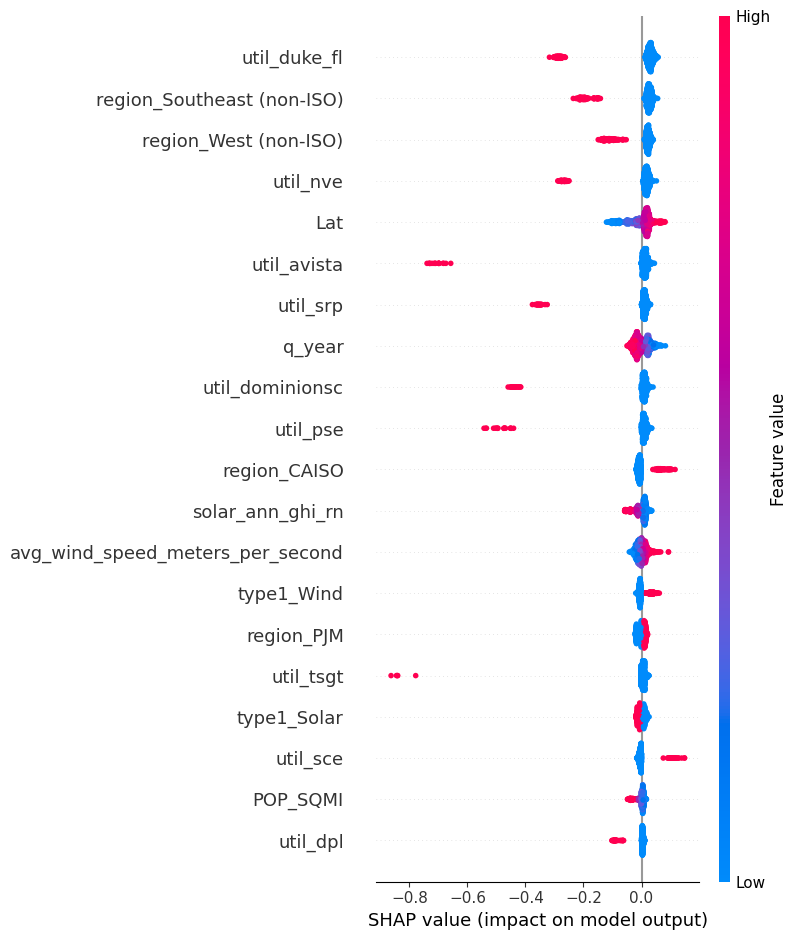

In [66]:
shap.summary_plot(shap_values, X_train)